# Latent Diffusion

WIP implementation of latent diffusion from the paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752). Right now the autoencoder architecture is copy/pasted from [this](https://blog.keras.io/building-autoencoders-in-keras.html) Keras tutorial and the U-Net code from [this one](https://keras.io/examples/generative/ddim/).

ToDo:
- Switch to VAE
- Find colored dataset to train on

In [31]:
import tensorflow as tf
from keras import layers
import keras
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
image_size  = 28
autoencoder_depth = 10
dropout = 0.1
channels = 1

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], image_size, image_size, channels))
x_test = np.reshape(x_test, (x_test.shape[0], image_size, image_size, channels))
x_train.shape

(60000, 28, 28, 1)

## Autoencoder

In [5]:
def EncoderBlock():
    def apply(x):
        x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
        return encoded
        
    return apply

def DecoderBlock():
    def apply(x):
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(16, (3, 3), activation='relu')(x)
        x = layers.UpSampling2D((2, 2))(x)
        decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
        return decoded
    
    return apply
    
def create_autoencoder():
    input_image = layers.Input(shape=(image_size, image_size, channels))
    encoded = EncoderBlock()(input_image)
    # At this point the representation is (4, 4, 8) i.e. 128-dimensional.
    decoded = DecoderBlock()(encoded)
    
    autoencoder = keras.Model(input_image, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder = keras.Model(input_image, encoded)
    
    return autoencoder, encoder

# Decoder should only be created after autoencoder has been trained.
def create_decoder(base_model):
    latent_input = layers.Input(shape=(4, 4, 8))
    decoded = DecoderBlock()(latent_input)
    decoder = keras.Model(latent_input, decoded)
    
    for i in range(7):
        decoder.layers[i+1].set_weights(base_model.layers[i+7].get_weights())
        
    return decoder

In [6]:
autoencoder, encoder = create_autoencoder()
autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test, x_test))
decoder = create_decoder(autoencoder)

Epoch 1/10
469/469 [==============================] - 10s 4ms/step - loss: 0.2033 - val_loss: 0.1443
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1348 - val_loss: 0.1260
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1231 - val_loss: 0.1186
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1175 - val_loss: 0.1143
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1137 - val_loss: 0.1112
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1108 - val_loss: 0.1088
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1086 - val_loss: 0.1064
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1068 - val_loss: 0.1050
Epoch 9/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1053 - val_loss: 0.1036
Epoch 10/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1041 - val_loss: 0.102

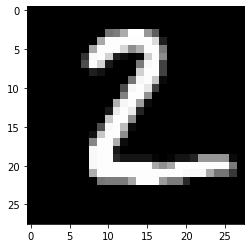

In [7]:
plt.imshow(x_test[1].reshape(28, 28), cmap='gray')

313/313 [==============================] - 0s 827us/step


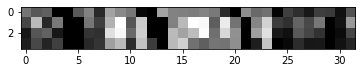

In [8]:
encoded_images = encoder.predict(x_test)
plt.imshow(encoded_images[0].reshape((4, 4 * 8)), cmap='gray')

313/313 [==============================] - 0s 792us/step


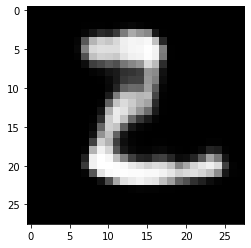

In [9]:
decoded_images2 = decoder.predict(encoded_images)
plt.imshow(decoded_images2[1].reshape(28, 28), cmap='gray')

## Denoising U-Net

In [19]:
# Sampling.
min_signal_rate = 0.02
max_signal_rate = 0.95

# Architecture.
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

In [49]:
def diffusion_schedule(diffusion_times):
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

In [21]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(tf.linspace(tf.math.log(embedding_min_frequency),
                         tf.math.log(embedding_max_frequency),
                         embedding_dims // 2))
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat([tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3)
    return embeddings

In [22]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, (1, 1))(x)
            
        x = layers.Conv2D(width, (3, 3), padding='same', activation=keras.activations.swish)(x)
        x = layers.LayerNormalization()(x + residual)
        return x
    
    return apply

In [43]:
def DownBlock(width, block_depth):
    def apply(x):
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x
        
    return apply

In [39]:
def UpBlock(width, block_depth):
    def apply(x):
        x = layers.UpSampling2D(size=2, interpolation='bilinear')(x)
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
        return x
    
    return apply

In [40]:
def create_unet(widths, block_depth):
    noisy_images = keras.Input(shape=(4, 4, 8))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=4, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    for width in widths[:-1]:
        x = DownBlock(width, block_depth)(x)

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)(x)

    x = layers.Conv2D(8, kernel_size=1, kernel_initializer="zeros")(x)
    
    unet = keras.Model([noisy_images, noise_variances], x, name="residual_unet")
    unet.compile(optimizer='adam', loss='mean_absolute_error')
    return unet

In [80]:
def train(train_data, model, epochs, batch_size):
    steps_per_epoch = int(train_data.shape[0] / batch_size)
    
    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            images = train_data[step * batch_size : step * batch_size + batch_size]
            noises = tf.random.normal(shape=(batch_size, 4, 4, 8))
            
            diffusion_times = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0)
            noise_rates, signal_rates = diffusion_schedule(diffusion_times)

            noisy_images = signal_rates * images + noise_rates * noises
            model.train_on_batch([noisy_images, noise_rates**2], noises)
        
        print('Epoch ' + str(epoch) + ' completed.')

In [81]:
def reverse_diffusion(model, num_images, diffusion_steps):
    initial_noise = tf.random.normal(shape=(num_images, 4, 4, 8))
    step_size = 1.0 / diffusion_steps
    
    next_noisy_images = initial_noise
    for step in range(diffusion_steps):
        noisy_images = next_noisy_images
        
        diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
        noise_rates, signal_rates = diffusion_schedule(diffusion_times)
        
        pred_noises = model([noisy_images, noise_rates**2])
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = diffusion_schedule(next_diffusion_times)
        next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
        
    return pred_images

In [155]:
unet = create_unet([32, 64, 32], 4)

In [ ]:
train(encoded_images, unet, 1000, 512)

In [150]:
generated_latents = reverse_diffusion(unet, 8, 20)

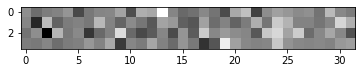

In [151]:
plt.imshow(generated_latents[2].numpy().reshape(4, 4 * 8), cmap='gray')

In [136]:
generated_images = decoder.predict(generated_latents)

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


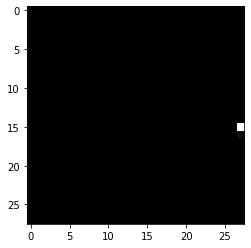

In [164]:
generated_latents = reverse_diffusion(unet, 2, 20)
generated_images = decoder.predict(generated_latents)
plt.imshow(generated_images[0].reshape(28, 28), cmap='gray')